# Time Series Analysis with Statsmodels

In this notebook, we will look at the Python package statsmodels to explore crypto prices. Let's dive in!

In [56]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

folder = f'../02.Prepared_data/2021-04-11/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df

In [57]:
coins = load_coins(folder)

# HP Filter: Cyclical and trend

In [58]:
btc_cycle, btc_trend = hpfilter(coins['BTC'], lamb=1600)

<AxesSubplot:xlabel='date'>

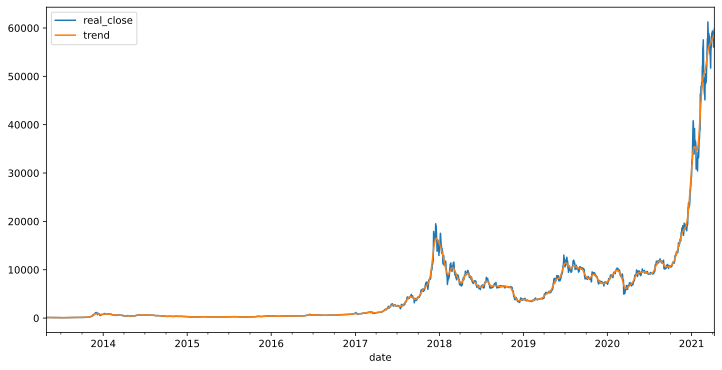

In [59]:
BTC = pd.DataFrame()
BTC['real_close'] = coins['BTC']
BTC['trend'] = btc_trend
BTC.loc[:].plot(figsize=(12,6))

<AxesSubplot:xlabel='date'>

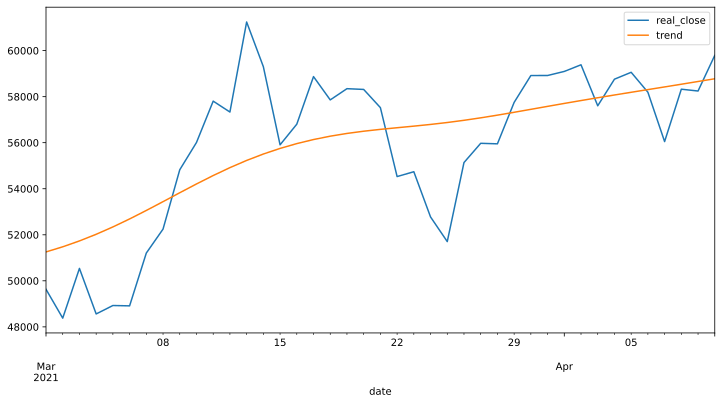

In [60]:
BTC.loc['2021-03-01':].plot(figsize=(12,6))

# ETS Models

ETS are Error Trend Seasonality

- Exponential Smoothing
- Trend Methods Models
- ETS Decomposition 

Statsmodel has seasonal decomposition tools to seaparate out different components (e.g. HP filter above).

ETS Decomposition returns 4 plots"

1. Observed plot
2. Trend component: general growth / decline pattern (trend)
3. Seasonal: isolated seasonal, basically removing any trend
4. Residual or error term: components not explained by trend or seasonal term. Can be a good indicator where there is a lot of noise in the dataset.

There is an additive and a multiplicative model. Additive is used when trend is more linear and seasonality and trend component seem to be constant over time (e.g. every day another +10 is added).

Multiplicative model is used when increase or decrease is at a nonlinear rate (e.g. every day the amount is x2).

<AxesSubplot:xlabel='date'>

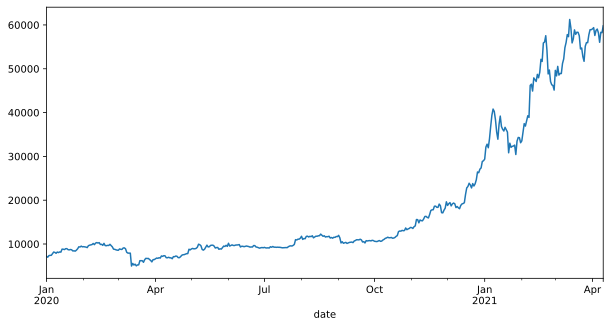

In [61]:
BTC = coins['BTC'].loc['2020':,]
BTC.plot()

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [63]:
result = seasonal_decompose(BTC, model='multiplicative')
result

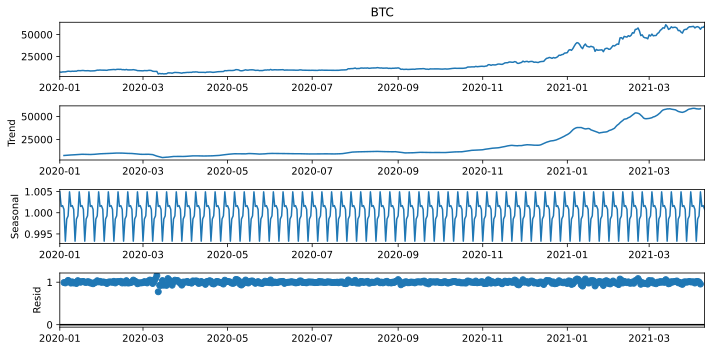

In [64]:
from pylab import rcParams

rcParams['figure.figsize'] = 10,5


result.plot();

<AxesSubplot:xlabel='date'>

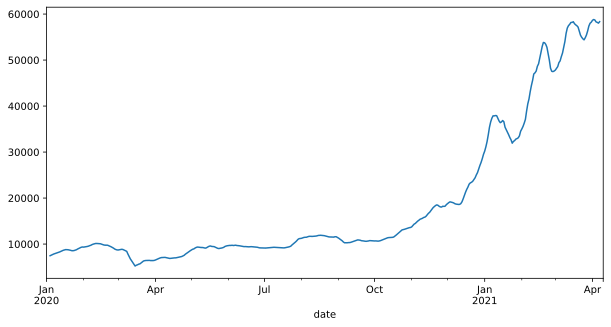

In [65]:
result.trend.plot(figsize=(10,5))

# EWMA - Exponentially Weighted Moving Average

Not for forecasting, but to describe the general behaviour of the time series.

An issue with Simple Moving Average (SMA) is that the entire model is contrained to the same, single window size. It would be nice to have more recent data weighted higher, it is more reflective of future results (still we don't use EWMA for forecasting).

Some weaknesses of SMA:

- Smaller windows will lead to more noise, rather than sginal
- SMA will always lag by the size of the window
- Will never reach to the full peak of the data due to the averaging (even for very small window sizes)
- Does not inform aout possible future behaviour, just describes general trends
- Extreme historical values can skew the SMA significantly (for the entire window basically)


In EWMA, the amount of weight applied to recent values depends on actual parameters used and the number of periods given the windo size. 


$$y_t \frac{\sum_{i=0}^{t}w_i x_{t-1}}{\sum_{i=0}^{t}w_i}$$

where
- $w$ applied weight (that changes from $i=0$ to $i=t$)
- $x$ input value

by default, adjust is True and thus weighted averages are calculated using weights ($(1-\alpha)$ is basically $w$ and the formula is expanded out):

$$y_t = \frac{x_t + (1-\alpha) x_{t-1} + (1-\alpha)^2 x_{t-2} + ... _ (1-\alpha)^t x_{0}}{x_t + (1-\alpha) x_{t-1} + (1-\alpha)^2 + ... _ (1-\alpha)^t }$$

If adjusted is false, then:

$$y_0 = x_0$$
$$y_t = (1-\alpha) y_{t-1} + \alpha x_t$$

It must be that $\alpha$ is between 0 and 1, however, it is best to think of the span of an EW moment:

$$\alpha=\frac{2}{s+1}$$

Span is called an "N-day exponentially weighted moving average."


<AxesSubplot:xlabel='date'>

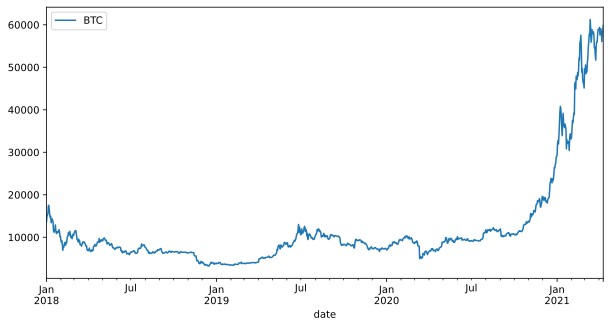

In [66]:
BTC = coins[['BTC']].loc['2018':,]
BTC.plot()

In [67]:
BTC['SMA_20week'] = BTC['BTC'].rolling(window=20*7).mean()

(2794.2365694363643, 100000.0)

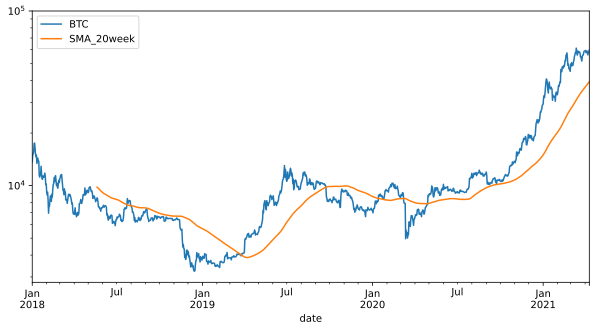

In [68]:
BTC.plot()
plt.yscale("log")
plt.ylim(plt.ylim()[0], 1e5)

In [69]:
BTC['EWMA_20week'] = BTC['BTC'].ewm(span=20*7).mean()

(2794.2365694363643, 100000.0)

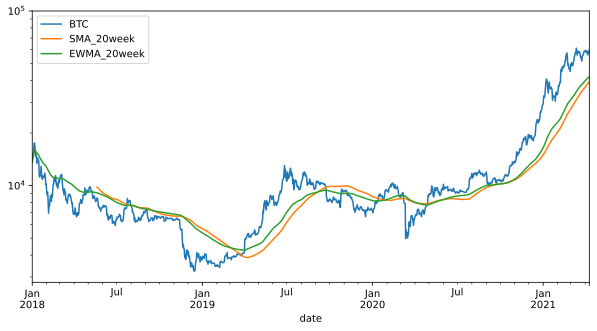

In [70]:
BTC.plot()
plt.yscale("log")
plt.ylim(plt.ylim()[0], 1e5)

# Holt-Winters method


Problem with EWMA is that uses simple smoothing using one factor $\alpha$. This fails to account for additional contributing factors such as seasonality or trend.

Holt-Winters comprises of the forecast equation and three smoothing equations. 

- One for the level $l_t$, one for trend $b_t$ and one for seasonal component $s_t$. Each have a corresponding smoothing parameter $\alpha$, $\beta$, $\gamma$.


- There are two variations to he method that differ in the nature of the seaonal component:

    - Additive method: preferred when seasonal variations are more or less constant throughout the series
    - Multiplicative method: preferred when the seasonal variations change proportional to the level of the series
    
   
- Base method, Single Exponential Smoothing:


$$y_0 = x_0$$
$$y_t = (1-\alpha) y_{t-1} + \alpha x_t$$


- Double Exponential Smoothing: Introduce $\beta$, new smoothing factor, that addresses the trend component:

    - level at time t: $$l_t = (1-\alpha) l_{t-1} + \alpha x_t$$
    - general trend: $$b_t = (1-\beta) b_{t-1} + \beta (l_t-l_{t-1})$$
    - relate the two, fitted model: $$y_t = l_t + b_t$$
    - predict some periods ahead ($h$ is number of periods in the future): $$\hat{y}_{t+h} = l_t + h b_t$$
    
    
As of now, there is no seasonal component, so the model is only considering to predict a general trend upward or downward.


- Triple Exponential Smoothing: Introduce $\gamma$, another smoothing factor, that addresses the seasonality component:

    - level at time t: $$l_t = (1-\alpha) l_{t-1} + \alpha x_t$$
    - general trend: $$b_t = (1-\beta) b_{t-1} + \beta (l_t-l_{t-1})$$
    - seasonal component: $$c_t = (1-\gamma) c_{t-L} + \gamma (x_t-l_{t-1}-b_{t-1})$$
    - relate the two, fitted model: $$y_t = (l_t + b_t) c_t$$
    - predict some periods ahead ($m$ is number of periods in the future): $$\hat{y}_{t+m} = (l_t + m b_t) c_{t-L+1+(m-1) mod(L)}$$
    
    $L$ is the number of divisions per cycle, so if looking at monthly data that displays a repeating pattern each year, one would set $L=12$.

<AxesSubplot:xlabel='date'>

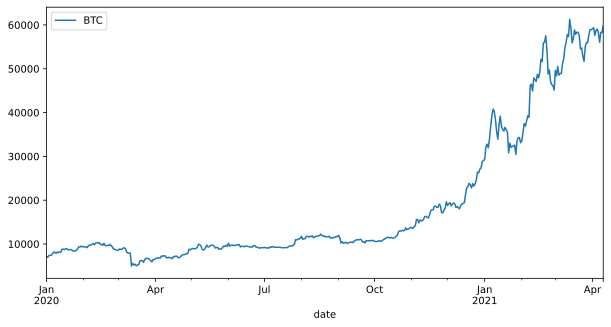

In [120]:
BTC = coins[['BTC']].loc['2020':,]
BTC.plot()

In [121]:
BTC.index.freq = "D"
BTC.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
               '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
               '2021-04-09', '2021-04-10'],
              dtype='datetime64[ns]', name='date', length=466, freq='D')

In [122]:
BTC.head()

,BTC
date,
2020-01-01,7200.17
2020-01-02,6985.47
2020-01-03,7344.88
2020-01-04,7410.66
2020-01-05,7411.32


## Single Exponential Smoothing

In [123]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [124]:
span = 365 # 365 days in a year
alpha = 2/(span+1)

alpha

0.00546448087431694

In [125]:
BTC["EWMA365"] = BTC['BTC'].ewm(alpha=alpha, adjust=False).mean()
BTC.head()

,BTC,EWMA365
date,,
2020-01-01,7200.17,7200.170000
2020-01-02,6985.47,7198.996776
2020-01-03,7344.88,7199.793952
2020-01-04,7410.66,7200.946226
2020-01-05,7411.32,7202.095809


In [126]:
model = SimpleExpSmoothing(BTC["BTC"])
fitted_model = model.fit(smoothing_level=alpha, optimized=False)

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [127]:
fitted_model.fittedvalues

date
2020-01-01     7200.170000
2020-01-02     7200.170000
2020-01-03     7198.996776
2020-01-04     7199.793952
2020-01-05     7200.946226
                  ...     
2021-04-06    26599.337031
2021-04-07    26771.976500
2021-04-08    26931.959907
2021-04-09    27103.500837
2021-04-10    27273.672963
Freq: D, Length: 466, dtype: float64

Because we set optimized to False, the values are shifted by one.

In [128]:
fitted_model.fittedvalues.shift(-1)

date
2020-01-01     7200.170000
2020-01-02     7198.996776
2020-01-03     7199.793952
2020-01-04     7200.946226
2020-01-05     7202.095809
                  ...     
2021-04-06    26771.976500
2021-04-07    26931.959907
2021-04-08    27103.500837
2021-04-09    27273.672963
2021-04-10             NaN
Freq: D, Length: 466, dtype: float64

In [129]:
BTC["SES365"] = fitted_model.fittedvalues.shift(-1)
BTC

,BTC,EWMA365,SES365
date,,,
2020-01-01,7200.17,7200.170000,7200.170000
2020-01-02,6985.47,7198.996776,7198.996776
2020-01-03,7344.88,7199.793952,7199.793952
2020-01-04,7410.66,7200.946226,7200.946226
2020-01-05,7411.32,7202.095809,7202.095809
...,...,...,...
2021-04-06,58192.36,26771.976500,26771.976500
2021-04-07,56048.94,26931.959907,26931.959907
2021-04-08,58323.95,27103.500837,27103.500837


## Additive Double Exponential Smoothing

In [130]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [131]:

BTC["DES_add_365"] = ExponentialSmoothing(BTC["BTC"], # DES = double exponential smoothing
                                          trend="add" # straight sloped trendline: add, curved: multiplicative, see description
                                         ).fit().fittedvalues.shift(-1)
BTC["DES_add_365"].head()

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


date
2020-01-01    6984.159683
2020-01-02    6775.585972
2020-01-03    7131.559001
2020-01-04    7211.901188
2020-01-05    7219.318446
Freq: D, Name: DES_add_365, dtype: float64

<AxesSubplot:xlabel='date'>

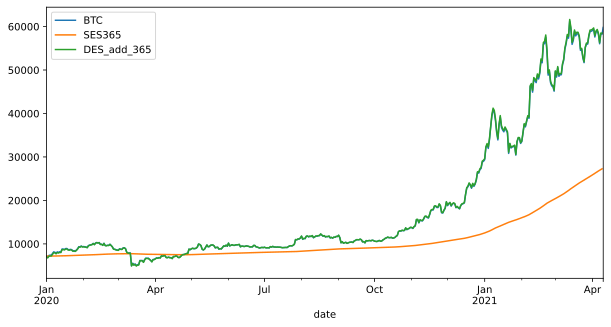

In [132]:
BTC[['BTC', "SES365", "DES_add_365"]].plot()

Double exponential smoothing (green) seems to perform much better than single exponential smoothing (orange). It is very close to the real data (blue).

<AxesSubplot:xlabel='date'>

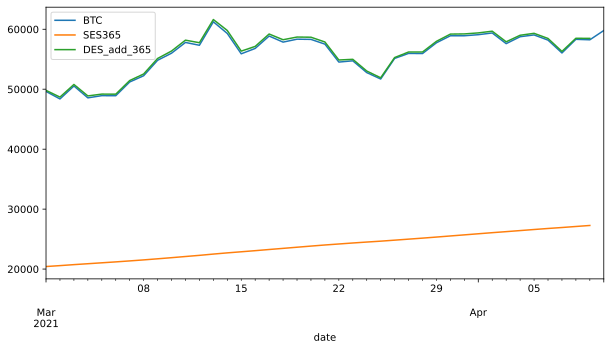

In [134]:
BTC[['BTC', "SES365", "DES_add_365"]].loc['Mar 2021':].plot()

## Multiplicative Double Exponential Smoothing

In [136]:

BTC["DES_mul_365"] = ExponentialSmoothing(BTC["BTC"], # DES = double exponential smoothing
                                          trend="mul" # straight sloped trendline: add, curved: multiplicative, see description
                                         ).fit().fittedvalues.shift(-1)
BTC["DES_mul_365"].head()

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


date
2020-01-01    6984.338490
2020-01-02    6781.845507
2020-01-03    7128.466262
2020-01-04    7206.657204
2020-01-05    7214.056505
Freq: D, Name: DES_mul_365, dtype: float64

<AxesSubplot:xlabel='date'>

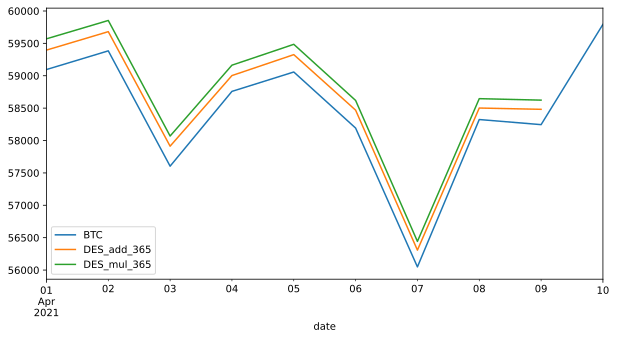

In [142]:
BTC[['BTC', "DES_add_365", "DES_mul_365"]].loc["Apr 2021":].plot()

## Triple Exponential Smoothing

In [148]:
BTC.columns

Index(['BTC', 'EWMA365', 'SES365', 'DES_add_365', 'DES_mul_365', 'TES_mul_365',
       'TES_add_365'],
      dtype='object')

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

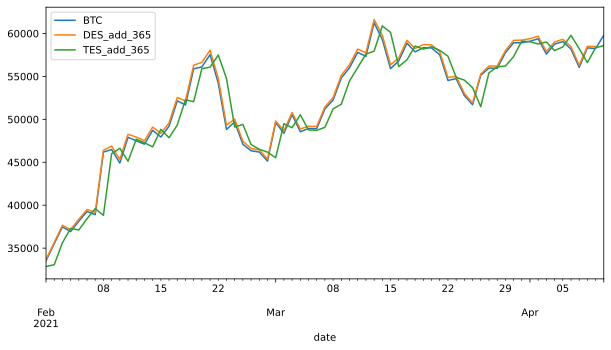

In [156]:
BTC["TES_mul_365"] = ExponentialSmoothing(BTC["BTC"], trend="mul", seasonal='mul', seasonal_periods=200).fit().fittedvalues
BTC["TES_add_365"] = ExponentialSmoothing(BTC["BTC"], trend="add", seasonal='add', seasonal_periods=12).fit().fittedvalues

BTC[['BTC', "DES_add_365", "TES_add_365"]].loc["Feb 2021":].plot()